In [28]:
import matplotlib.patches as patches
import torch

import torchvision.transforms as T
from matplotlib import pyplot as plt

from dataset.FastPatchExtractor import FastPatchExtractor
from kernels import mean_kernel_generator, gaussian_kernel_generator
from core.Transforms import image_normalization
from patchNr.Operators import BlurOperator
from utils.img_utils import ImageLoader

In [29]:
file = "./data/set12/01.png"
ground_truth_image = ImageLoader(file, transform=T.Compose([
    image_normalization()]))

In [30]:
kernel_size = 5

In [31]:
single_kernel = torch.zeros((kernel_size, kernel_size)).unsqueeze(0).unsqueeze(0)
single_kernel[0][0][kernel_size//2, kernel_size//2] = 1
blur_operator = BlurOperator(single_kernel, device='cpu')
mean_kernel = mean_kernel_generator(kernel_size)
blur_operator_mean = BlurOperator(mean_kernel, device='cpu')
gauss_kernel = gaussian_kernel_generator(kernel_size, std=1)
blur_operator_gauss = BlurOperator(gauss_kernel, device='cpu')
motion_kernel = (1/5)*torch.eye(5, 5).unsqueeze(0).unsqueeze(0)
blur_operator_motion = BlurOperator(motion_kernel)

In [32]:
def plot_images(path, img0, kernel, selected_patch=(100, 100), p_size=30):
    image0 = img0.to('cpu')
    out_dim = (p_size, p_size)
    patch_extractor = FastPatchExtractor(p_dim=30, pad=True)
    c, x, y = image0.size()
    p_x, p_y = selected_patch
    p_pos = p_y*x + p_x
    p_image0 = torch.reshape(patch_extractor.extract(image0.unsqueeze(0))[p_pos], out_dim)
    fig, axes = plt.subplots(3, 1, figsize=(1.5, 4.5))
    rect1 = patches.Rectangle((p_x, p_y), p_size, p_size, linewidth=1, edgecolor='r',facecolor='none')
    axes[0].imshow(image0.squeeze(), cmap='gray')
    axes[0].add_patch(rect1)
    axes[0].axis('off')
    axes[1].imshow(p_image0.squeeze(), cmap='gray')
    axes[1].axis('off')
    axes[2].imshow(kernel.squeeze(), cmap='gray', vmin=0, vmax=0.4)
    axes[2].axis('off')
    fig.tight_layout()
    fig.show()
    fig.savefig(path)

In [33]:
position = (80,100)
patch_size = 30
plot_images('images/kernel_exp/gt.png', blur_operator(ground_truth_image), single_kernel ,selected_patch=position, p_size=patch_size)
plot_images('images/kernel_exp/mean.png', blur_operator_mean(ground_truth_image), mean_kernel, selected_patch=position, p_size=patch_size)
plot_images('images/kernel_exp/gauss.png', blur_operator_gauss(ground_truth_image), gauss_kernel, selected_patch=position, p_size=patch_size)
plot_images('kernel_exp/motion.png', blur_operator_motion(ground_truth_image), motion_kernel, selected_patch=position, p_size=patch_size)

TypeError: img should be PIL Image. Got <class 'utils.img_utils.ImageLoader'>

In [7]:
patch_extractor = FastPatchExtractor(p_dim=8)
patch = patch_extractor.extract(ground_truth_image)[256*100+100].reshape((8,8))
plt.imshow(patch, cmap='gray')
plt.show()

RuntimeError: "im2col_out_cpu" not implemented for 'Byte'

In [8]:
kernel = mean_kernel_generator(3)
kernel = kernel.squeeze()
ker_w, ker_h = kernel.size()

In [14]:
w, h = patch.size()

In [15]:
block_w = ker_w+w-1
block_h = ker_h+h-1
print(block_w, block_h)

10 10


In [1]:

import torch.nn.functional as F
import torch

In [2]:
def get_2D_toeplitz(kernel, input_dims):
    img_row, img_col = input_dims
    k_row, k_col = kernel.size()
    t_row = img_row-k_row+1
    t_col = img_col-k_col+1
    print(t_row, t_col)
    padded_kernel = F.pad(kernel, pad=(0, t_col-k_col, 0, t_row-k_row))
    pk_row, pk_col = padded_kernel.shape
    toeplitz_blocks = [ toeplitz(row, pk_row) for row in padded_kernel]
    res_col = torch.arange(1, len(toeplitz_blocks)+1)
    res_row = torch.zeros()
    res_row[0] = 1
    shape = toeplitz(res_col, res_row).flatten('F')
    zero_block = np.zeros((padded_kernel.size(1), t_row))
    ordered_blocks = []
    for block_id in shape:
        if block_id == 0:
            ordered_blocks.append(zero_block)
        else:
            ordered_blocks.append(toeplitz_blocks[block_id-1])
    return np.vstack(np.dstack(np.stack(ordered_blocks).reshape((2,3,padded_kernel.size(0),t_row))))

In [3]:
kernel = torch.arange(1,5).reshape((2,2))
print(kernel)

NameError: name 'torch' is not defined

In [ ]:
toeplitz_matrix = get_2D_toeplitz(kernel, (3,2))

In [ ]:
padded_kernel = F.pad(kernel, pad=(0, img_w-k_w, 0, img_h-k_h))

In [ ]:
padded_kernel.shape

In [407]:
padded_kernel

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0751, 0.1238, 0.0751, 0.0000],
        [0.1238, 0.2042, 0.1238, 0.0000],
        [0.0751, 0.1238, 0.0751, 0.0000]])

In [401]:
from scipy.linalg import toeplitz
import numpy as np
toeplitz_col = padded_kernel.flatten()
toeplitz_row = torch.zeros(toeplitz_col.size(0))
toeplitz_row[0] = toeplitz_col[0]
matrix = toeplitz(toeplitz_row, toeplitz_col)
print(matrix.shape)
matrix = np.delete(matrix, [16-i for i in range(1, (toeplitz_col.size(0)//2+1) + img_w - k_w)], 0)

(16, 16)


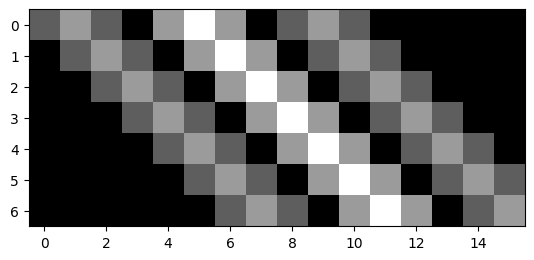

In [402]:
plt.imshow(matrix, cmap='gray')
plt.show()